In [466]:
import pandas as pd
from pandas import json_normalize
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Get Data

In [13]:
test_df = pd.read_csv('/Users/maksimtrebusinin/Downloads/test_csv.csv')
test_df

,ip,http_version,method,user_agent,js_fingerprint.fingerprint,js_fingerprint.fingerprints.persistentFp,js_fingerprint.fingerprints.uniqueFp,js_fingerprint.profile.applePay,js_fingerprint.profile.attributionsourceid,js_fingerprint.profile.audioContext,...,os_prediction.scores.Android,os_prediction.scores.Windows,os_prediction.scores.Mac OS,os_prediction.scores.iOS,os_prediction.scores.Linux,os_prediction.platform_mismatch,blacklist_info.blacklist_info.ip,blacklist_info.blacklist_info.TotalBlacklists,blacklist_info.blacklist_info.CountFoundIn,blacklist_info.blacklist_info.FoundIn
0,165.227.55.199,h2,POST,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,1541781108,2250950024,1541781108,"[-1,null]","[-1,null]","[0,35.73833402246237]",...,3.12,3.08,2.41,2.3,3.93,True,165.227.55.199,10,2,"[""b.barracudacentral.org"",""bb.barracudacentral..."


In [269]:
data_list = []
columns = test_df.columns
with open('/Users/maksimtrebusinin/Downloads/fingerprints_with_os_checked.json') as file:
    for line in file:
        try:
            # Разбираем каждую строку как отдельный JSON-объект
            obj = json.loads(line.strip())
            data_list.append(obj)
        except json.JSONDecodeError as e:
            print(f"Ошибка при декодировании строки: {e}")

print(f'Count of JSON objects: {len(data_list)}')

keylist = [el.split('.') for el in columns]

def get_data(key, data):
    if len(key) == 1:
        key = key[0]
        try:
            return data[key]
        except Exception as e:
            return np.nan
    elif len(key) == 2:
        key1, key2, = key
        try:
            return data[key1][key2]
        except Exception as e:
            return np.nan
    elif len(key) == 3:
        key1, key2, key3 = key
        try:
            return data[key1][key2][key3]
        except Exception as e:
            return np.nan

data_frame = pd.DataFrame(columns=columns)
count = 1
for data in data_list:
    obj = []
    for key in keylist:
        obj.append(get_data(key=key,data=data))
    prom_df = pd.DataFrame([obj], columns=columns)
    data_frame = pd.concat([data_frame, prom_df], ignore_index=True)
    if count % 200 == 0:
        print(f'Lengh of data: {len(data_frame)}')
data_frame.info()

Count of JSON objects: 7448
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7448 entries, 0 to 7447
Data columns (total 94 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ip                                             7448 non-null   object 
 1   http_version                                   7448 non-null   object 
 2   method                                         7448 non-null   object 
 3   user_agent                                     7448 non-null   object 
 4   js_fingerprint.fingerprint                     4200 non-null   object 
 5   js_fingerprint.fingerprints.persistentFp       4200 non-null   object 
 6   js_fingerprint.fingerprints.uniqueFp           4200 non-null   object 
 7   js_fingerprint.profile.applePay                4200 non-null   object 
 8   js_fingerprint.profile.attributionsourceid     4200 non-null   object 
 9   js_fingerprint.profile.a

In [200]:
with open('/Users/maksimtrebusinin/Downloads/scamalytics_rechecked.json') as f:
    rechecked_data = json.load(f)
rech_keys = [x for x in rechecked_data['79.210.243.3'].keys()]
objects = []
for el in rechecked_data:
    objects.append(np.array([x for x in rechecked_data[el].values()]))
rech_df = pd.DataFrame(data = objects, columns = rech_keys)

In [204]:
rech_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ip                       2334 non-null   object
 1   score                    2334 non-null   object
 2   risk                     2334 non-null   object
 3   is_blacklisted_external  2334 non-null   object
 4   isp                      2334 non-null   object
 5   organization             2334 non-null   object
dtypes: object(6)
memory usage: 109.5+ KB


# EDA

In [241]:
def is_there_dupl(key):
    key_columns = [x for x in data_frame.columns if key in x]
    if data_frame[key_columns].duplicated().sum() > 0:
        key_columns.append('ip')
        print(data_frame[key_columns][data_frame[key_columns].duplicated() == True])
    else:
        print('No duplicates!')

In [233]:
tls_columns = [x for x in data_frame.columns if 'tls' in x]
if data_frame[tls_columns].drop(['tls.extensions','tls.ciphers'], axis=1).duplicated().sum() > 0:
    tls_columns.append('ip')
    data_frame[tls_columns]
else:
    print('No duplicates!')

No duplicates!


In [270]:
is_there_dupl('tcp')

     tcpip.cap_length tcpip.dst_port tcpip.src_port tcpip.ip.id tcpip.ip.tos  \
869               NaN            NaN            NaN         NaN          NaN   
871               NaN            NaN            NaN         NaN          NaN   
872               NaN            NaN            NaN         NaN          NaN   
7363              NaN            NaN            NaN         NaN          NaN   

     tcpip.ip.ttl tcpip.ip.ip_version tcpip.ip.dst_ip tcpip.ip.src_ip  \
869           NaN                 NaN             NaN             NaN   
871           NaN                 NaN             NaN             NaN   
872           NaN                 NaN             NaN             NaN   
7363          NaN                 NaN             NaN             NaN   

     tcpip.tcp.checksum tcpip.tcp.mss tcpip.tcp.options  \
869                 NaN           NaN               NaN   
871                 NaN           NaN               NaN   
872                 NaN           NaN               NaN 

In [271]:
data_frame.drop([869, 871, 872, 6490, 7363], axis=0, inplace=True)
data_frame.drop('http2.sent_frames', axis=1, inplace=True)

In [272]:
# Разделение akamai_fingerprint на составляющие
data_frame['akamai_fingerprint.settings'] = data_frame['http2.akamai_fingerprint'].apply(lambda x: x.split('|')[0])
data_frame['akamai_fingerprint.window_update'] = data_frame['http2.akamai_fingerprint'].apply(lambda x: x.split('|')[1])
data_frame['akamai_fingerprint.priority_weights'] = data_frame['http2.akamai_fingerprint'].apply(lambda x: x.split('|')[2])
data_frame['akamai_fingerprint.flags'] = data_frame['http2.akamai_fingerprint'].apply(lambda x: x.split('|')[3])

# Удаление исходного столбца
data_frame.drop(columns=['http2.akamai_fingerprint'], inplace=True)

In [273]:
js_columns = ['js_fingerprint.fingerprint','js_fingerprint.fingerprints.persistentFp','js_fingerprint.fingerprints.uniqueFp',
             'js_fingerprint.profile.deviceMemory','js_fingerprint.profile.screenResolution','js_fingerprint.profile.userAgentData',
             'js_fingerprint.profile.platform']
data_frame.drop([x for x in data_frame.columns if x not in 'js' in x and x not in js_columns], axis=1, inplace=True)

In [321]:
data_frame.reset_index(drop=True, inplace=True)

In [329]:
data_frame.drop(['tcpip.cap_length','tcpip.dst_port','tcpip.src_port','tcpip.ip.id',
                'tcpip.ip.tos','tcpip.ip.dst_ip','tcpip.ip.src_ip','tcpip.tcp.checksum',
                'tcpip.tcp.options','tcpip.tcp.options_order','tcpip.tcp.seq', 'tcpip.tcp.options'], axis=1, inplace=True)

In [351]:
data_frame['tls_version'] = data_frame['tls.ja3'].apply(lambda x: x.split(',')[0])
data_frame['ciphers'] = data_frame['tls.ja3'].apply(lambda x: x.split(',')[1])
data_frame['expansions'] = data_frame['tls.ja3'].apply(lambda x: x.split(',')[2])
data_frame['supp_gr'] = data_frame['tls.ja3'].apply(lambda x: x.split(',')[3])
data_frame['signature_algorithms'] = data_frame['tls.ja3'].apply(lambda x: x.split(',')[4])

data_frame.drop(['tls.ciphers','tls.extensions','tls.tls_version_record','tls.peetprint',
                'tls.peetprint','tls.client_random','tls.session_id'], axis=1, inplace=True)

In [369]:
data_frame.drop(['os_prediction.platform_mismatch','blacklist_info.blacklist_info.ip','blacklist_info.blacklist_info.FoundIn'],
               axis=1, inplace = True)

In [373]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7443 entries, 0 to 7442
Data columns (total 38 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ip                                             7443 non-null   object 
 1   http_version                                   7443 non-null   object 
 2   method                                         7443 non-null   object 
 3   user_agent                                     7443 non-null   object 
 4   js_fingerprint.fingerprint                     4198 non-null   object 
 5   js_fingerprint.fingerprints.persistentFp       4198 non-null   object 
 6   js_fingerprint.fingerprints.uniqueFp           4198 non-null   object 
 7   js_fingerprint.profile.deviceMemory            4198 non-null   object 
 8   js_fingerprint.profile.platform                4198 non-null   object 
 9   js_fingerprint.profile.screenResolution        4198 

In [380]:
data_frame_with_out_js = data_frame.drop([x for x in data_frame.columns if 'js' in x], axis=1)
del js

In [388]:
for col in data_frame_with_out_js.columns:
    print(f'{col} - {data_frame_with_out_js[col][0]}')

ip - 165.227.55.199
http_version - h2
method - POST
user_agent - Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/113.0
tls.tls_version_negotiated - 772
tls.ja3 - 771,4865-4867-4866-49195-49199-52393-52392-49196-49200-49162-49161-49171-49172-156-157-47-53,0-23-65281-10-11-16-5-34-51-43-13-45-28-41,29-23-24-25-256-257,0
tls.ja3_hash - c279b0189edb9269da7bc43dea5e0c36
tls.ja4 - t13d1714h2_5b57614c22b0_b64a002ba4e8
tls.peetprint_hash - fea33d3783ae74d495240377b44baa68
http2.akamai_fingerprint_hash - fd4f649c50a64e33cc9e2407055bafbe
tcpip.ip.ttl - 45
tcpip.ip.ip_version - 4
tcpip.tcp.mss - 1460
tcpip.tcp.window - 64240
os_prediction.highest - Linux
os_prediction.scores.Android - 3.12
os_prediction.scores.Windows - 3.08
os_prediction.scores.Mac OS - 2.41
os_prediction.scores.iOS - 2.3
os_prediction.scores.Linux - 3.93
blacklist_info.blacklist_info.TotalBlacklists - 10
blacklist_info.blacklist_info.CountFoundIn - 2
akamai_fingerprint.settings - 1:65536,4:131072,5:1638

In [394]:
data_frame_with_out_js.dropna(inplace=True)
columns_for_switch_type = ['tls.tls_version_negotiated','tcpip.ip.ttl','tcpip.ip.ip_version','tcpip.tcp.mss',
                          'tcpip.tcp.window','blacklist_info.blacklist_info.TotalBlacklists','blacklist_info.blacklist_info.CountFoundIn',
                          'akamai_fingerprint.window_update','tls_version']
for col in columns_for_switch_type:
    data_frame_with_out_js[col] = data_frame_with_out_js[col].astype('int')

In [397]:
for col in data_frame_with_out_js.select_dtypes('object').columns:
    data_frame_with_out_js[col] = LabelEncoder().fit_transform(data_frame_with_out_js[col])
data_frame_with_out_js['os_prediction.highest'].value_counts()

3    4921
1    1105
4     854
0     544
2      18
Name: os_prediction.highest, dtype: int64

In [ ]:
# Android: 0
# Linux: 1
# Mac OS: 2
# Windows: 3
# iOS: 4

In [403]:
data_frame_with_out_js[data_frame_with_out_js['os_prediction.highest'] == 2]

,ip,http_version,method,user_agent,tls.tls_version_negotiated,tls.ja3_hash,tls.ja4,tls.peetprint_hash,http2.akamai_fingerprint_hash,tcpip.ip.ttl,...,blacklist_info.blacklist_info.CountFoundIn,akamai_fingerprint.settings,akamai_fingerprint.window_update,akamai_fingerprint.priority_weights,akamai_fingerprint.flags,tls_version,ciphers,expansions,supp_gr,signature_algorithms
1506,1186,0,1,291,772,2585,34,43,8,54,...,0,43,10485760,0,4,771,6,174,5,0
1507,1186,0,2,291,772,2585,34,43,8,54,...,0,43,10485760,0,4,771,6,174,5,0
1688,2202,0,1,144,772,649,11,45,24,49,...,4,15,15663105,0,0,771,2,2807,3,0
1689,2202,0,2,144,772,5163,15,33,24,48,...,4,15,15663105,0,0,771,2,4738,3,0
2539,1184,0,1,291,772,2585,34,43,8,53,...,0,43,10485760,0,4,771,6,174,5,0
2540,1184,0,2,291,772,2585,34,43,8,53,...,0,43,10485760,0,4,771,6,174,5,0
2549,1184,0,1,291,772,2585,34,43,8,51,...,0,43,10485760,0,4,771,6,174,5,0
2550,1184,0,2,291,772,2585,34,43,8,53,...,0,43,10485760,0,4,771,6,174,5,0
2560,1875,0,1,291,772,2585,34,43,8,48,...,6,43,10485760,0,4,771,6,174,5,0
2561,1875,0,2,291,772,2585,34,43,8,48,...,6,43,10485760,0,4,771,6,174,5,0


In [404]:
for col in data_frame_with_out_js.columns:
    print(f'{col} - {data_frame_with_out_js[col].nunique()} unique values')

ip - 2333 unique values
http_version - 1 unique values
method - 3 unique values
user_agent - 303 unique values
tls.tls_version_negotiated - 2 unique values
tls.ja3_hash - 5377 unique values
tls.ja4 - 43 unique values
tls.peetprint_hash - 64 unique values
http2.akamai_fingerprint_hash - 54 unique values
tcpip.ip.ttl - 58 unique values
tcpip.ip.ip_version - 1 unique values
tcpip.tcp.mss - 73 unique values
tcpip.tcp.window - 35 unique values
os_prediction.highest - 5 unique values
blacklist_info.blacklist_info.TotalBlacklists - 1 unique values
blacklist_info.blacklist_info.CountFoundIn - 10 unique values
akamai_fingerprint.settings - 51 unique values
akamai_fingerprint.window_update - 9 unique values
akamai_fingerprint.priority_weights - 2 unique values
akamai_fingerprint.flags - 5 unique values
tls_version - 1 unique values
ciphers - 23 unique values
expansions - 5359 unique values
supp_gr - 11 unique values
signature_algorithms - 2 unique values


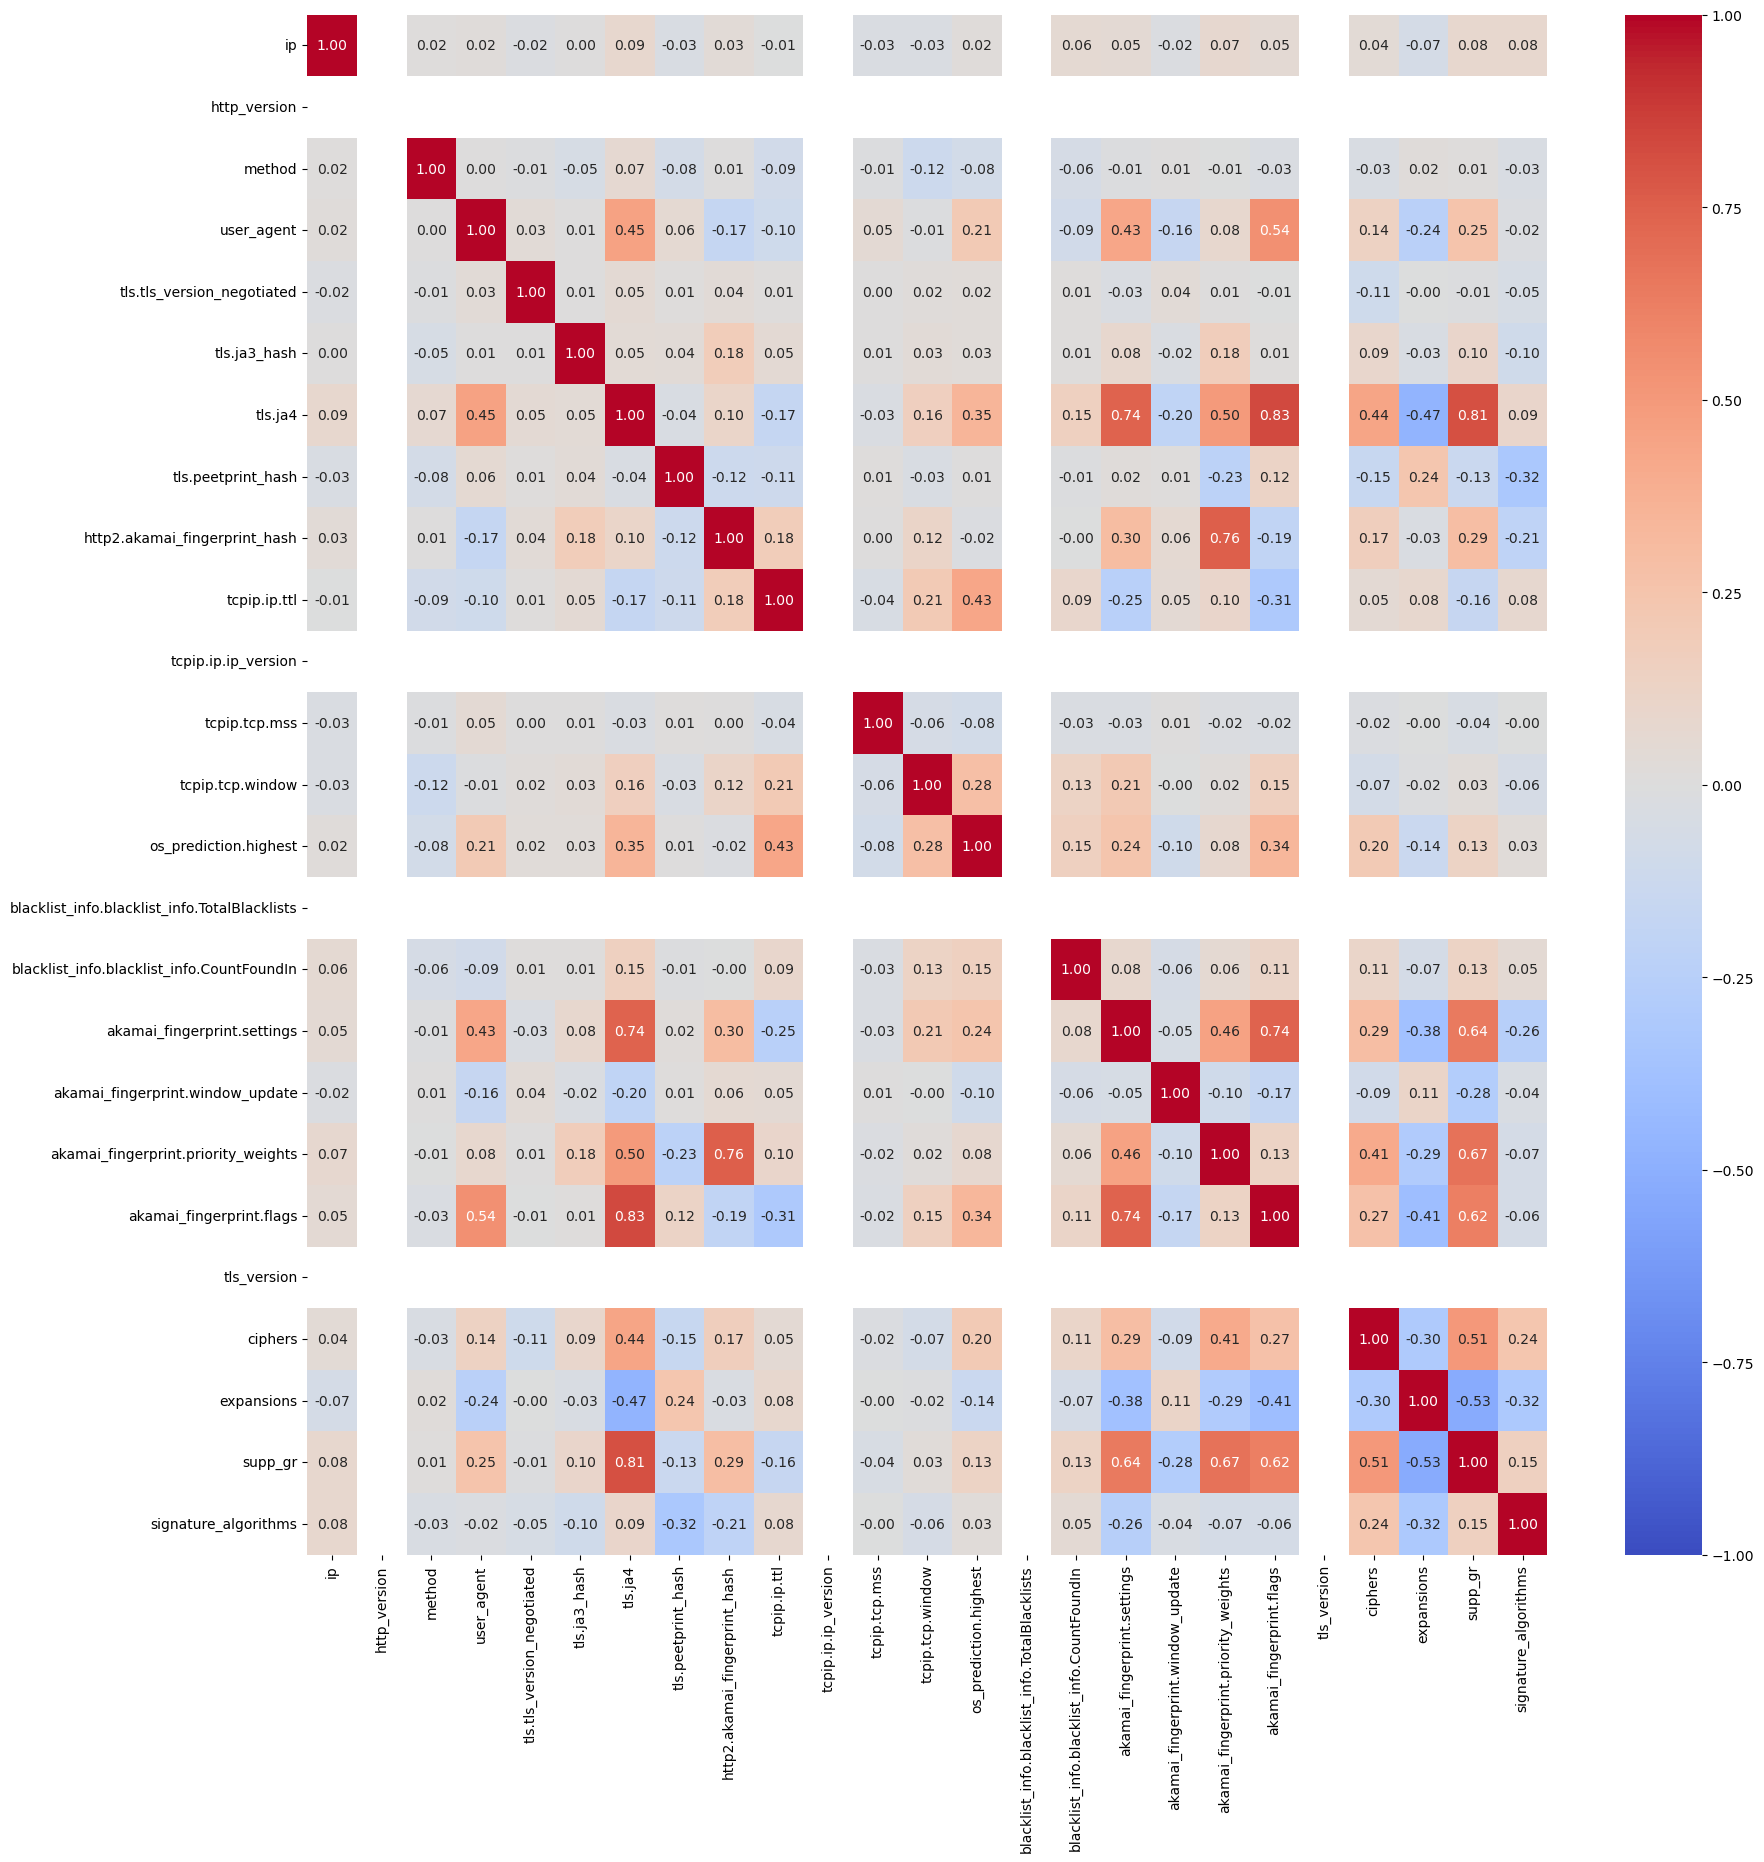

In [410]:
plt.figure(figsize=(20,20))
sns.heatmap(data_frame_with_out_js.select_dtypes('int').corr(), annot = True, cmap='coolwarm', vmin=-1, center=0, vmax=1, fmt='.2f')
plt.show()

# Training and Testing models

In [420]:
models = [XGBClassifier(), CatBoostClassifier(verbose=False), RandomForestClassifier()]
X,y = data_frame_with_out_js.drop('os_prediction.highest', axis=1), data_frame_with_out_js['os_prediction.highest']
X_tr, X_t, y_tr, y_t = train_test_split(X,y, test_size=0.25, random_state=42, stratify=y)
for model in models:
    model.fit(X_tr,y_tr)
    pred = model.predict(X_t)
    print(f'Accuarcy: {accuracy_score(y_t,pred)}')
    print(f'F1_score: {f1_score(y_t,pred, average="weighted")}')
    print('----------')

Accuarcy: 0.9962385814078453
F1_score: 0.9962525440810633
----------
Accuarcy: 0.9935518538420204
F1_score: 0.993416394100496
----------
Accuarcy: 0.9865663621708759
F1_score: 0.9863846619764531
----------


In [425]:
xgb = XGBClassifier()
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
for scoring in ['f1_macro', 'f1_micro', 'f1_weighted','recall_weighted']:
    cross_val = cross_val_score(xgb, X,y, cv=cv, scoring=scoring)
    print(f'{scoring} - {cross_val.mean()}')

f1_macro - 0.9871234377331729
f1_micro - 0.9952963487648706
f1_weighted - 0.995277880301388
recall_weighted - 0.9952963487648706


In [433]:
def cross_val(df, list_of_scores, model):
    X,y = df.drop('os_prediction.highest', axis=1), df['os_prediction.highest']
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    for scoring in list_of_scores:
        cross_v = cross_val_score(model, X,y, cv=cv, scoring=scoring)
        print(f'{scoring} - {cross_v.mean()}')

In [434]:
test = data_frame_with_out_js.drop(['user_agent','tls.ja3_hash','tls.peetprint_hash'], axis=1)
xgb = XGBClassifier()
cross_val(test, ['f1_macro', 'f1_micro', 'f1_weighted','recall_weighted'], xgb)

f1_macro - 0.9661218813010382
f1_micro - 0.990324746778959
f1_weighted - 0.9902972176830057
recall_weighted - 0.990324746778959


In [451]:
test.drop_duplicates(inplace=True)

In [452]:
X,y = test.drop('os_prediction.highest', axis=1), test['os_prediction.highest']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
print(f'y_train labesl: {np.bincount(y_train)}')
print(f'y_test labesl: {np.bincount(y_test)}')

rnf = RandomForestClassifier()
rnf.fit(X_train,y_train)
y_pred = rnf.predict(X_test)
print(f'f1_macro: {f1_score(y_test, y_pred, average="macro")}')

y_train labesl: [ 377  702   12 3106  452]
y_test labesl: [ 161  301    5 1332  194]
f1_macro: 0.8972143164045144


In [ ]:
import joblib

joblib.dump(rnf, 'random_forest_model.pkl')

# Interpretation

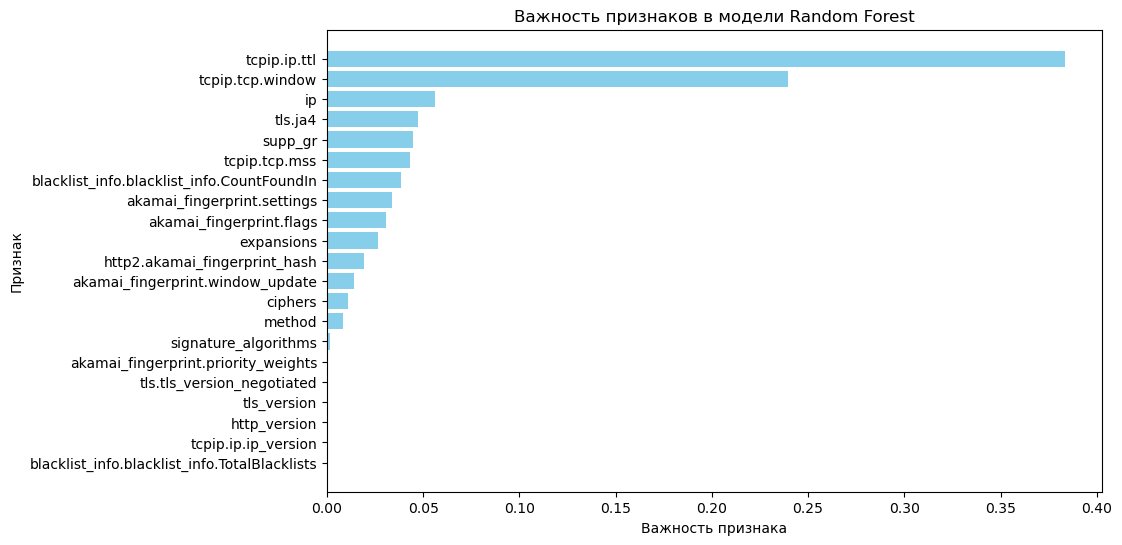

In [453]:
importances = rnf.feature_importances_
feature_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели Random Forest')
plt.gca().invert_yaxis()  # Инвертируем ось Y для удобства чтения
plt.show()

In [460]:
grouped = test.groupby('os_prediction.highest')

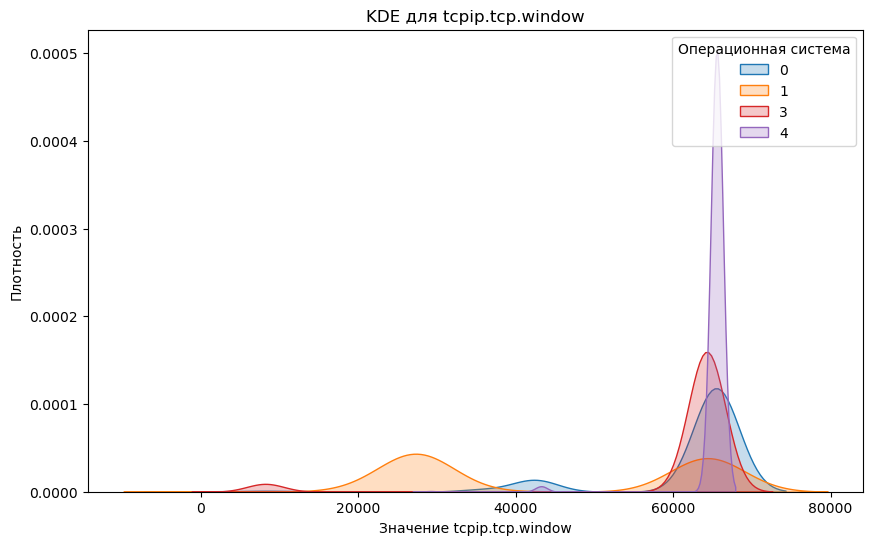

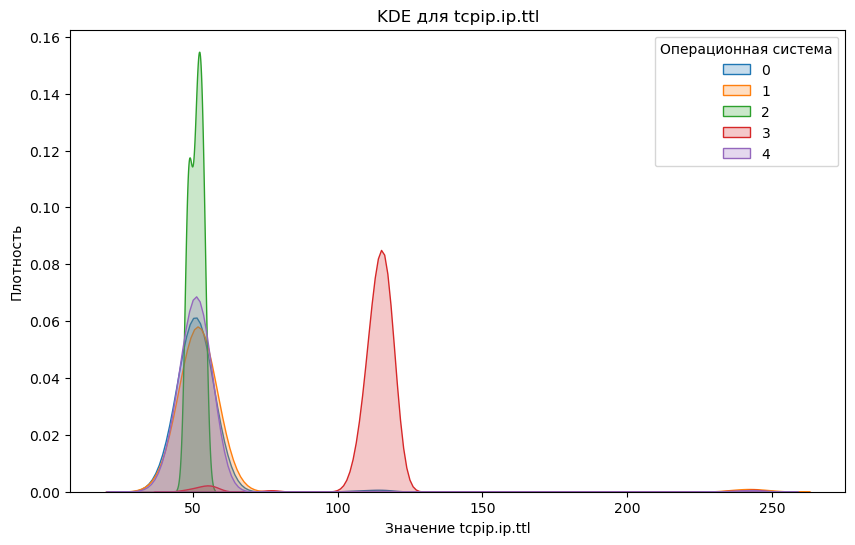

In [467]:
# Построение KDE для 'tcpip.tcp.window'
plt.figure(figsize=(10, 6))
for os, group in grouped:
    sns.kdeplot(group['tcpip.tcp.window'], label=os, shade=True)
plt.title('KDE для tcpip.tcp.window')
plt.xlabel('Значение tcpip.tcp.window')
plt.ylabel('Плотность')
plt.legend(title='Операционная система')
plt.show()

# Построение KDE для 'tcpip.ip.ttl'
plt.figure(figsize=(10, 6))
for os, group in grouped:
    sns.kdeplot(group['tcpip.ip.ttl'], label=os, shade=True)
plt.title('KDE для tcpip.ip.ttl')
plt.xlabel('Значение tcpip.ip.ttl')
plt.ylabel('Плотность')
plt.legend(title='Операционная система')
plt.show()